# IMPORTS

In [184]:
from sklearn.utils.validation import check_consistent_length, check_array

def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):
    """Mean absolute percentage error regression loss.
    Note here that we do not represent the output as a percentage in range
    [0, 100]. Instead, we represent it in range [0, 1/eps]. Read more in the
    :ref:`User Guide <mean_absolute_percentage_error>`.
    .. versionadded:: 0.24
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    multioutput : {'raw_values', 'uniform_average'} or array-like
        Defines aggregating of multiple output values.
        Array-like value defines weights used to average errors.
        If input is list then the shape must be (n_outputs,).
        'raw_values' :
            Returns a full set of errors in case of multioutput input.
        'uniform_average' :
            Errors of all outputs are averaged with uniform weight.
    Returns
    -------
    loss : float or ndarray of floats in the range [0, 1/eps]
        If multioutput is 'raw_values', then mean absolute percentage error
        is returned for each output separately.
        If multioutput is 'uniform_average' or an ndarray of weights, then the
        weighted average of all output errors is returned.
        MAPE output is non-negative floating point. The best value is 0.0.
        But note the fact that bad predictions can lead to arbitarily large
        MAPE values, especially if some y_true values are very close to zero.
        Note that we return a large value instead of `inf` when y_true is zero.
    Examples
    --------
    >>> from sklearn.metrics import mean_absolute_percentage_error
    >>> y_true = [3, -0.5, 2, 7]
    >>> y_pred = [2.5, 0.0, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    0.3273...
    >>> y_true = [[0.5, 1], [-1, 1], [7, -6]]
    >>> y_pred = [[0, 2], [-1, 2], [8, -5]]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    0.5515...
    >>> mean_absolute_percentage_error(y_true, y_pred, multioutput=[0.3, 0.7])
    0.6198...
    """
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
        y_true, y_pred, multioutput)
    check_consistent_length(y_true, y_pred, sample_weight)
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

def _check_reg_targets(y_true, y_pred, multioutput, dtype="numeric"):
    """Check that y_true and y_pred belong to the same regression task.
    Parameters
    ----------
    y_true : array-like
    y_pred : array-like
    multioutput : array-like or string in ['raw_values', uniform_average',
        'variance_weighted'] or None
        None is accepted due to backward compatibility of r2_score().
    Returns
    -------
    type_true : one of {'continuous', continuous-multioutput'}
        The type of the true target data, as output by
        'utils.multiclass.type_of_target'.
    y_true : array-like of shape (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples, n_outputs)
        Estimated target values.
    multioutput : array-like of shape (n_outputs) or string in ['raw_values',
        uniform_average', 'variance_weighted'] or None
        Custom output weights if ``multioutput`` is array-like or
        just the corresponding argument if ``multioutput`` is a
        correct keyword.
    dtype : str or list, default="numeric"
        the dtype argument passed to check_array.
    """
    check_consistent_length(y_true, y_pred)
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)

    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape((-1, 1))

    if y_true.shape[1] != y_pred.shape[1]:
        raise ValueError("y_true and y_pred have different number of output "
                         "({0}!={1})".format(y_true.shape[1], y_pred.shape[1]))

    n_outputs = y_true.shape[1]
    allowed_multioutput_str = ('raw_values', 'uniform_average',
                               'variance_weighted')
    if isinstance(multioutput, str):
        if multioutput not in allowed_multioutput_str:
            raise ValueError("Allowed 'multioutput' string values are {}. "
                             "You provided multioutput={!r}".format(
                                 allowed_multioutput_str,
                                 multioutput))
    elif multioutput is not None:
        multioutput = check_array(multioutput, ensure_2d=False)
        if n_outputs == 1:
            raise ValueError("Custom weights are useful only in "
                             "multi-output cases.")
        elif n_outputs != len(multioutput):
            raise ValueError(("There must be equally many custom weights "
                              "(%d) as outputs (%d).") %
                             (len(multioutput), n_outputs))
    y_type = 'continuous' if n_outputs == 1 else 'continuous-multioutput'

    return y_type, y_true, y_pred, multioutput

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.ensemble import BaggingRegressor

from google.colab import drive
drive.mount('/drive')

RANDOM_SEED = 42
VAL_SIZE = 0.2

# settings to display all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > '/drive/My Drive/Segodnya_DS/requirements.txt'

def get_metric(y_true, y_pred):
    return np.mean(np.abs(((y_true - y_pred) / y_true)))


def get_boxplot(df, col):
    # draw a boxplot
    fig, axes = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='per_square_meter_price', y=col, data=df, ax=axes)
    axes.set_title('Boxplot for ' + col)
    plt.show()


def getFeaturesInfo(df):
    # num of unique values, first 10 unique values, null values count, type
    df_agg = df.agg({'nunique', lambda s: s.unique()[:10]})\
        .append(pd.Series(df.isnull().sum(), name='null'))\
        .append(pd.Series(df.dtypes, name='dtype'))\
        .transpose()
    
    return df_agg


import typing
from sklearn.metrics import r2_score, mean_squared_error

THRESHOLD = 0.15
NEGATIVE_WEIGHT = 1.1

def deviation_metric_one_sample(y_true: typing.Union[float, int], y_pred: typing.Union[float, int]) -> float:
    """
    Реализация кастомной метрики для хакатона.

    :param y_true: float, реальная цена
    :param y_pred: float, предсказанная цена
    :return: float, значение метрики
    """
    deviation = (y_pred - y_true) / np.maximum(1e-8, y_true)
    if np.abs(deviation) <= THRESHOLD:
        return 0
    elif deviation <= - 4 * THRESHOLD:
        return 9 * NEGATIVE_WEIGHT
    elif deviation < -THRESHOLD:
        return NEGATIVE_WEIGHT * ((deviation / THRESHOLD) + 1) ** 2
    elif deviation < 4 * THRESHOLD:
        return ((deviation / THRESHOLD) - 1) ** 2
    else:
        return 9


def deviation_metric(y_true: np.array, y_pred: np.array) -> float:
    return np.array([deviation_metric_one_sample(y_true[n], y_pred[n]) for n in range(len(y_true))]).mean()

def median_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.median(np.abs(y_pred-y_true)/y_true)

def metrics_stat(y_true: np.array, y_pred: np.array) -> typing.Dict[str,float]:
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mdape = median_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    raif_metric = deviation_metric(y_true, y_pred)
    return {'mape':mape, 'mdape':mdape, 'rmse': rmse, 'r2': r2, 'raif_metric':raif_metric}


train = pd.read_csv('/drive/My Drive/Segodnya_DS/train.csv', low_memory=False)
train.drop_duplicates(inplace=True)
train.dropna(subset=['osm_city_nearest_population'], inplace=True)
train = train.query('price_type == 1')
test = pd.read_csv('/drive/My Drive/Segodnya_DS/test.csv')
sample = pd.read_csv('/drive/My Drive/Segodnya_DS/test_submission.csv')


Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [186]:
# train.head(5).T

In [187]:
# train.info()

In [188]:
# test.head()

In [189]:
# test.info()

In [190]:
# sample.head()

In [191]:
# sample.info()

# EDA

In [192]:
getFeaturesInfo(train)

,<lambda>,nunique,null,dtype
city,"[Красноярск, Саратов, Иркутск, Белгород, Санкт...",189,0,object
floor,"[nan, 2.0, 1, -1.0, 1.0, 3.0, 18.0, подвал, 1,...",88,2463,object
id,"[COL_62, COL_71, COL_140, COL_202, COL_207, CO...",4492,0,object
lat,"[56.06361499599455, 51.534581216805535, 56.026...",3827,0,float64
lng,"[92.95842777343151, 46.02054934002936, 92.8183...",4492,0,float64
osm_amenity_points_in_0.001,"[0, 13, 3, 4, 18, 1, 2, 6, 12, 5]",33,0,int64
osm_amenity_points_in_0.005,"[7, 198, 15, 10, 48, 430, 20, 27, 5, 9]",297,0,int64
osm_amenity_points_in_0.0075,"[14, 345, 23, 26, 73, 731, 41, 77, 27, 6]",441,0,int64
osm_amenity_points_in_0.01,"[26, 462, 33, 40, 92, 1160, 84, 125, 52, 10]",589,0,int64
osm_building_points_in_0.001,"[0, 1, 2]",3,0,int64


In [193]:
getFeaturesInfo(test)

,<lambda>,nunique,null,dtype
city,"[Курск, Сургут, Тюмень, Иркутск, Кемерово, Кра...",165,0,object
floor,"[1.0, -1.0, nan, 2,3, 2, -2.0, 5.0, 4, 1, 5]",74,1301,object
id,"[COL_289284, COL_289305, COL_289318, COL_28935...",2974,0,object
osm_amenity_points_in_0.001,"[7, 8, 3, 5, 0, 1, 18, 12, 2, 9]",34,0,int64
osm_amenity_points_in_0.005,"[55, 70, 28, 76, 105, 18, 5, 20, 61, 31]",262,0,int64
osm_amenity_points_in_0.0075,"[85, 112, 67, 139, 189, 30, 7, 39, 83, 46]",386,0,int64
osm_amenity_points_in_0.01,"[117, 140, 122, 231, 279, 33, 20, 85, 125, 64]",507,0,int64
osm_building_points_in_0.001,"[0, 2, 1, 4]",4,0,int64
osm_building_points_in_0.005,"[0, 8, 1, 13, 2, 16, 9, 4, 3, 5]",17,0,int64
osm_building_points_in_0.0075,"[0, 2, 10, 1, 22, 32, 11, 3, 4, 6]",24,0,int64


## per_square_meter_price

In [194]:
train['per_square_meter_price'].isna().sum()

0

In [195]:
train['per_square_meter_price'].sort_values().head()

279567     1095.943175
279691     6710.338322
278035     7799.008704
278838     9279.601204
277781    10460.663221
Name: per_square_meter_price, dtype: float64

In [196]:
train['per_square_meter_price'].sort_values().tail()

278814    1.381949e+06
275895    1.421424e+06
275394    1.597727e+06
277342    1.767103e+06
278414    1.790993e+06
Name: per_square_meter_price, dtype: float64

In [197]:
# PRICE_CORRECTOR = train.groupby('price_type')['per_square_meter_price'].mean()[0] / train.groupby('price_type')['per_square_meter_price'].mean()[1]
# PRICE_CORRECTOR


## city

In [198]:
train['city'].isna().sum()

0

In [199]:
test['city'].isna().sum()

0

In [200]:
top_city = list(train['city'].value_counts().head(15).index)

train['city'] = train['city'].apply(lambda x: x if x in top_city else 'other')
test['city'] = test['city'].apply(lambda x: x if x in top_city else 'other')

In [201]:
train['city'].value_counts()

other              1547
Красноярск          543
Санкт-Петербург     374
Иркутск             358
Томск               227
Екатеринбург        193
Кемерово            172
Петрозаводск        160
Нижний Новгород     159
Новосибирск         133
Брянск              120
Белгород            114
Курск               107
Калуга              102
Омск                 92
Москва               91
Name: city, dtype: int64

In [202]:
test['city'].value_counts()

other              1043
Красноярск          405
Иркутск             228
Санкт-Петербург     205
Томск               138
Петрозаводск        136
Екатеринбург        127
Нижний Новгород      97
Кемерово             94
Белгород             82
Новосибирск          81
Курск                81
Омск                 75
Калуга               64
Брянск               62
Москва               56
Name: city, dtype: int64

## region

In [203]:
top_region = list(train['region'].value_counts().head(15).index)

train['region'] = train['region'].apply(lambda x: x if x in top_region else 'other')
test['region'] = test['region'].apply(lambda x: x if x in top_region else 'other')

In [204]:
train['region'].value_counts()

other                    1212
Красноярский край         594
Иркутская область         454
Санкт-Петербург           356
Кемеровская область       256
Томская область           229
Свердловская область      210
Карелия                   181
Нижегородская область     172
Курская область           136
Новосибирская область     133
Калужская область         123
Брянская область          122
Белгородская область      118
Орловская область         104
Омская область             92
Name: region, dtype: int64

In [205]:
test['region'].value_counts()

other                    847
Красноярский край        436
Иркутская область        285
Санкт-Петербург          203
Карелия                  144
Томская область          142
Свердловская область     138
Кемеровская область      134
Нижегородская область    101
Курская область           95
Новосибирская область     83
Белгородская область      83
Калужская область         80
Омская область            75
Брянская область          71
Орловская область         57
Name: region, dtype: int64

## floor

In [206]:
train['floor_empty'] = pd.isna(train['floor']).astype('uint8')
test['floor_empty'] = pd.isna(test['floor']).astype('uint8')



In [207]:
train['floor_multi'] = train['floor'].apply(lambda x: 1 if ',' in str(x) else 0)
test['floor_multi'] = test['floor'].apply(lambda x: 1 if ',' in str(x) else 0)


In [208]:
train['floor'].fillna(0.0, inplace=True)
test['floor'].fillna(0.0, inplace=True)


In [209]:
train['floor'] = train['floor'].apply(lambda x: 0 if 'цок' in str(x).lower()
                                      or 'подва' in str(x).lower()
                                      or 'этаж' in str(x).lower()
                                      or 'манс' in str(x).lower()
                                      or 'антрес' in str(x).lower()
                                      or 'мезон' in str(x).lower()
                                      or 'техн' in str(x).lower()
                                      or ',' in str(x).lower()
                                      or '-' in str(x).lower() else x)
test['floor'] = test['floor'].apply(lambda x: 0 if 'цок' in str(x).lower()
                                      or 'подва' in str(x).lower()
                                      or 'этаж' in str(x).lower()
                                      or 'манс' in str(x).lower()
                                      or 'антрес' in str(x).lower()
                                      or 'мезон' in str(x).lower()
                                      or 'техн' in str(x).lower()
                                      or ',' in str(x).lower()
                                      or '-' in str(x).lower() else x)

train['floor'] = train['floor'].apply(lambda x: int(float(str(x))))
test['floor'] = test['floor'].apply(lambda x: int(float(str(x))))


## total_square

In [210]:
train['total_square'].isna().sum()

0

In [211]:
test['total_square'].isna().sum()

0

In [212]:
# train['total_square'].sort_values()

In [213]:
# test['total_square'].sort_values()

## price_type

In [214]:
train['price_type'].value_counts()

1    4492
Name: price_type, dtype: int64

In [215]:
test['price_type'].value_counts()

1    2974
Name: price_type, dtype: int64

## reform

In [216]:
reform_cols = [
    'reform_house_population_1000',
    'reform_house_population_500',
    'reform_mean_floor_count_1000',
    'reform_mean_floor_count_500',
    'reform_mean_year_building_1000',
    'reform_mean_year_building_500'
]

for col in reform_cols:
    train[col] = train[col].fillna(train.groupby('city')[col].transform('median'))
    test[col] = test[col].fillna(test.groupby('city')[col].transform('median'))

# LABEL ENCODING

In [217]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [218]:
bin_cols = [
    'floor_empty',
    'floor_multi'
]

cat_cols = [
    'city',
    'realty_type',
]

num_cols = [
    'floor',
    'lat',
    'lng',
    'osm_amenity_points_in_0.01',
    'osm_catering_points_in_0.001',
    'osm_city_closest_dist',
    'osm_city_nearest_population',
    'osm_crossing_closest_dist',
    'osm_crossing_points_in_0.01',
    'osm_finance_points_in_0.01',
    'osm_healthcare_points_in_0.01',
    'osm_historic_points_in_0.005',
    'osm_hotels_points_in_0.01',
    'osm_leisure_points_in_0.01',
    'osm_offices_points_in_0.01',
    'osm_shops_points_in_0.01',
    'osm_subway_closest_dist',
    'osm_train_stop_closest_dist',
    'osm_train_stop_points_in_0.01',
    'osm_transport_stop_points_in_0.01',
    'reform_count_of_houses_1000',
    'reform_house_population_1000',
    'reform_mean_floor_count_1000',
    'reform_mean_floor_count_500',
    'reform_mean_year_building_1000',
]

for colum in cat_cols:
    data[colum] = data[colum].astype('category').cat.codes

## Feature Importance

In [219]:
# data_temp = data.loc[data['sample'] == 1].drop(['sample'], axis=1)

In [220]:
# imp_num = pd.Series(f_classif(data_temp[num_cols], data_temp['per_square_meter_price'])[0], index=num_cols)
# imp_num.sort_values(inplace=True)
# imp_num.plot(kind = 'barh', color='pink', title='Numeric Features Importance')

In [221]:
# imp_num

# osm_building_points is less important than other

## Get Dummies

In [222]:
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

In [223]:
cat_cols = [
    'city_0',
    'city_1',
    'city_2',
    'city_3',
    'city_4',
    'city_5',
    'city_6',
    'city_7',
    'city_8',
    'city_9',
    'city_10',
    'city_11',
    'city_12',
    'city_13',
    'city_14',
    'city_15',
    'realty_type_0',
    'realty_type_1',
    'realty_type_2'
]

## Outliers and Standartization

In [224]:
for col in num_cols:
    if col == 'floor' or col == 'lat' or col == 'lng':
        pass
    else:
        median = data[col].median()
        IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
        perc25 = data[col].quantile(0.25)
        perc75 = data[col].quantile(0.75)

        print("Column: ", col)
        print(' 25%: {:.4},\n'.format(perc25), '75%: {:.4},\n'.format(perc75),
              "IQR: {:.4}, \n".format(IQR), "Borderline: [{f:.4}, {l:.4}].\n".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
        print()

        # replace outliers with border-values
        data[col] = np.where(data[col] > (perc75 + 1.5*IQR), (perc75 + 1.5*IQR), data[col])
        data[col] = np.where(data[col] < (perc25 - 1.5*IQR), (perc25 - 1.5*IQR), data[col])

Column:  osm_amenity_points_in_0.01
 25%: 55.0,
 75%: 196.8,
 IQR: 141.8, 
 Borderline: [-157.6, 409.4].


Column:  osm_catering_points_in_0.001
 25%: 0.0,
 75%: 1.0,
 IQR: 1.0, 
 Borderline: [-1.5, 2.5].


Column:  osm_city_closest_dist
 25%: 1.304,
 75%: 4.745,
 IQR: 3.441, 
 Borderline: [-3.856, 9.906].


Column:  osm_city_nearest_population
 25%: 4.066e+05,
 75%: 1.157e+06,
 IQR: 7.501e+05, 
 Borderline: [-7.186e+05, 2.282e+06].


Column:  osm_crossing_closest_dist
 25%: 0.05987,
 75%: 0.1777,
 IQR: 0.1178, 
 Borderline: [-0.1169, 0.3545].


Column:  osm_crossing_points_in_0.01
 25%: 26.0,
 75%: 81.0,
 IQR: 55.0, 
 Borderline: [-56.5, 163.5].


Column:  osm_finance_points_in_0.01
 25%: 2.0,
 75%: 12.0,
 IQR: 10.0, 
 Borderline: [-13.0, 27.0].


Column:  osm_healthcare_points_in_0.01
 25%: 2.0,
 75%: 9.0,
 IQR: 7.0, 
 Borderline: [-8.5, 19.5].


Column:  osm_historic_points_in_0.005
 25%: 0.0,
 75%: 3.0,
 IQR: 3.0, 
 Borderline: [-4.5, 7.5].


Column:  osm_hotels_points_in_0.01
 25%

In [225]:
scaler = MinMaxScaler()
data[num_cols] = scaler.fit_transform(data[num_cols].values)

In [226]:
feat_cols = []
feat_cols.append('per_square_meter_price')
feat_cols.append('sample')
for item in [num_cols, bin_cols, cat_cols]:
    for elem in item:
        feat_cols.append(elem)

In [227]:
data = data[feat_cols]

In [228]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7466 entries, 0 to 7465
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   per_square_meter_price             4492 non-null   float64
 1   sample                             7466 non-null   int64  
 2   floor                              7466 non-null   float64
 3   lat                                7466 non-null   float64
 4   lng                                7466 non-null   float64
 5   osm_amenity_points_in_0.01         7466 non-null   float64
 6   osm_catering_points_in_0.001       7466 non-null   float64
 7   osm_city_closest_dist              7466 non-null   float64
 8   osm_city_nearest_population        7466 non-null   float64
 9   osm_crossing_closest_dist          7466 non-null   float64
 10  osm_crossing_points_in_0.01        7466 non-null   float64
 11  osm_finance_points_in_0.01         7466 non-null   float

## Correlation Matrix

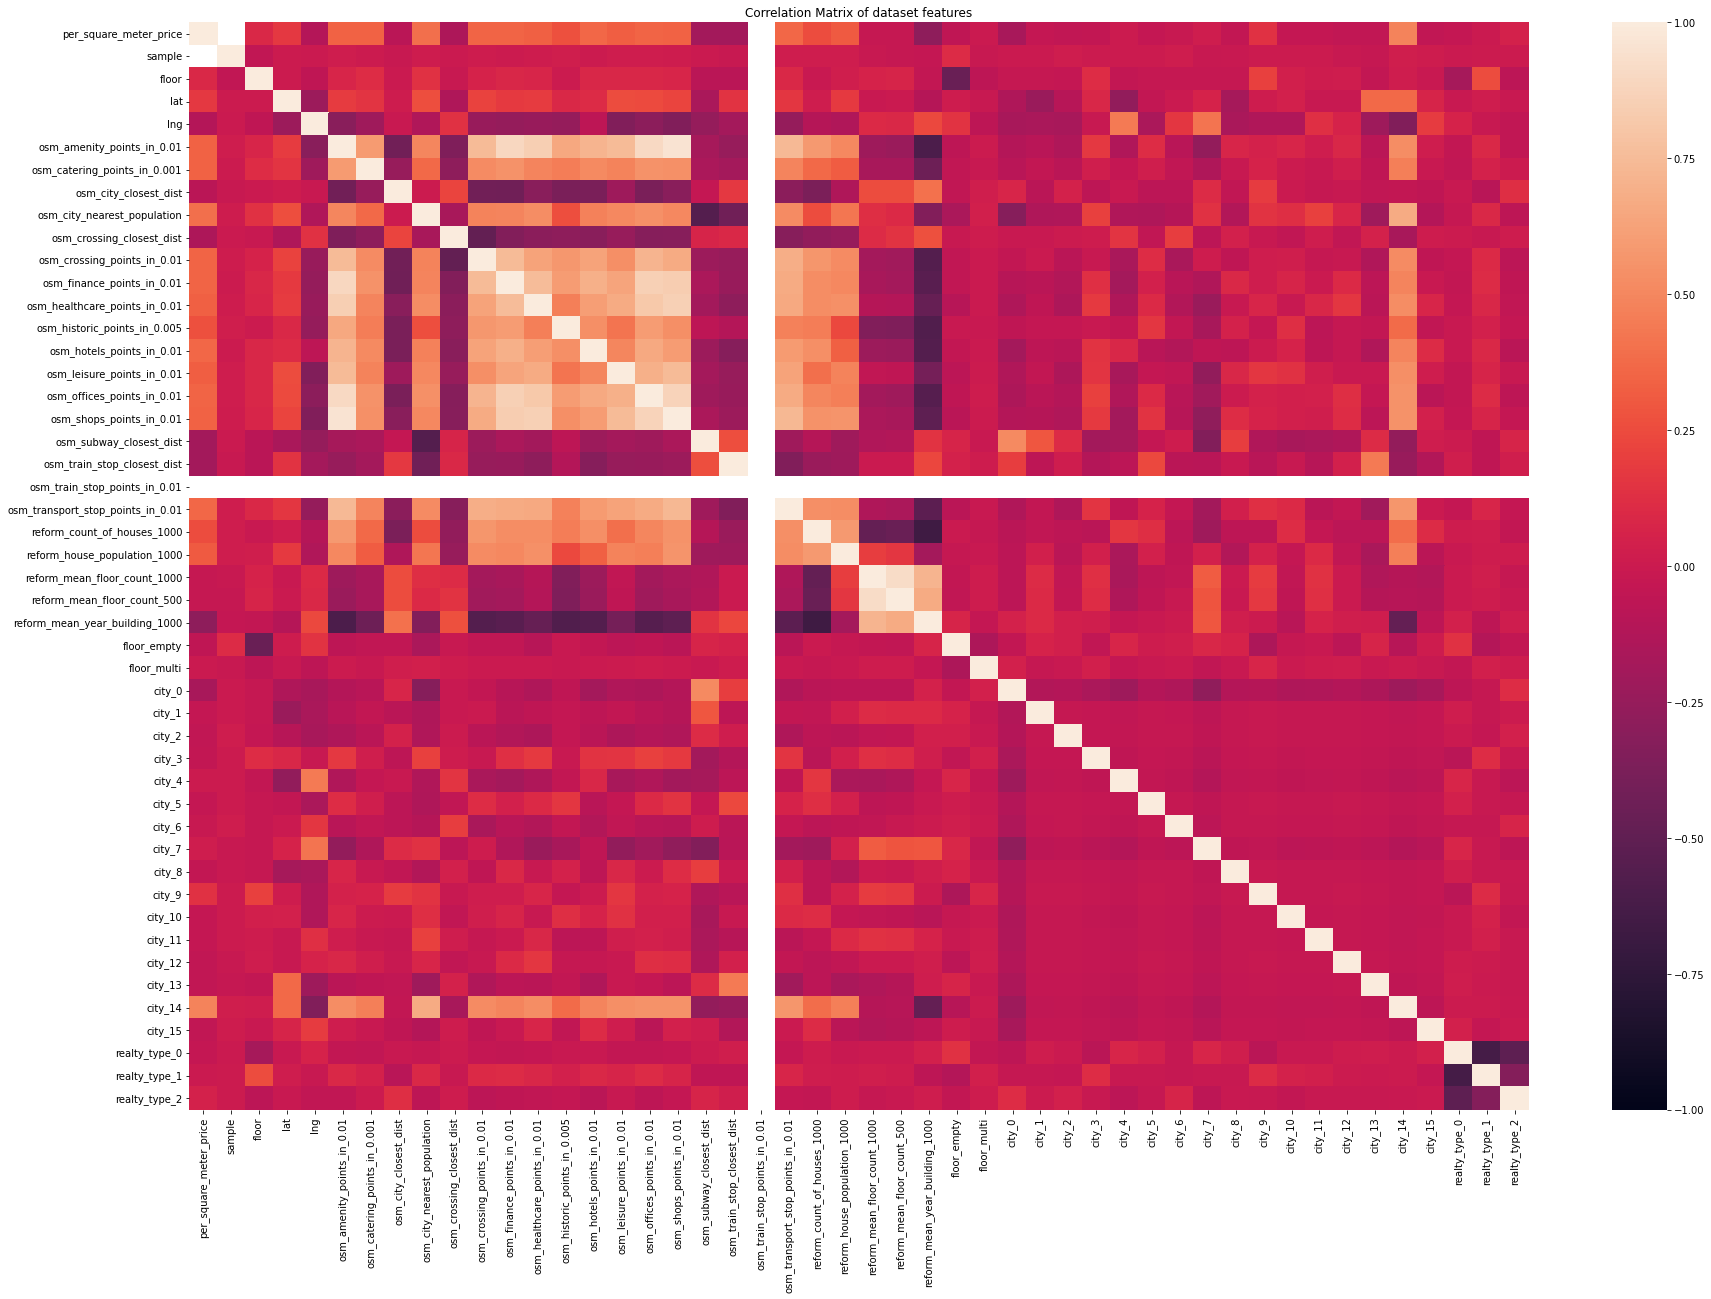

In [229]:
plt.title('Correlation Matrix of dataset features')
plt.rcParams['figure.figsize'] = (30,20)
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot = False)

In [230]:
# show features with corr > 0.7
corr = data.corr().abs()
corr_table = corr.unstack()
corr_table_sorted = corr_table.sort_values(kind="quicksort", ascending=False)
corr_exclude_ones = corr_table_sorted[corr_table_sorted != 1]
high_corr = corr_exclude_ones[corr_exclude_ones >= 0.7]
high_corr

osm_shops_points_in_0.01           osm_amenity_points_in_0.01           0.953312
osm_amenity_points_in_0.01         osm_shops_points_in_0.01             0.953312
reform_mean_floor_count_1000       reform_mean_floor_count_500          0.915123
reform_mean_floor_count_500        reform_mean_floor_count_1000         0.915123
osm_offices_points_in_0.01         osm_amenity_points_in_0.01           0.902879
osm_amenity_points_in_0.01         osm_offices_points_in_0.01           0.902879
osm_finance_points_in_0.01         osm_amenity_points_in_0.01           0.894109
osm_amenity_points_in_0.01         osm_finance_points_in_0.01           0.894109
osm_shops_points_in_0.01           osm_offices_points_in_0.01           0.872903
osm_offices_points_in_0.01         osm_shops_points_in_0.01             0.872903
osm_healthcare_points_in_0.01      osm_shops_points_in_0.01             0.858475
osm_shops_points_in_0.01           osm_healthcare_points_in_0.01        0.858475
osm_offices_points_in_0.01  

# MODEL

In [231]:
train = data.query('sample == 1')
test = data.query('sample == 0')

X = train.drop(['sample', 'per_square_meter_price'], axis=1).values
y = train['per_square_meter_price'].values

X_sub = test.drop(['sample', 'per_square_meter_price'], axis=1).values

In [232]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [233]:
start = datetime.now()

lgbmr = LGBMRegressor(objective='regression', max_depth=12, num_leaves=1000,
                      learning_rate=0.02, n_estimators=2000, metric='mape')

lgbmr.fit(X_train, np.log(y_train))

# оцениваем точность
predict_lgbmr = np.exp(lgbmr.predict(X_val))
print(f"Точность модели по метрике MAPE: {(deviation_metric(y_val, predict_lgbmr)):0.2f}%")
print('Время выполнения - ', datetime.now() - start)

Точность модели по метрике MAPE: 1.55%
Время выполнения -  0:00:09.557617


In [234]:
# lgbm for total_square = 200.19%
# lgbm for total_square w query price_type 1 = 46.11%
# lgbm for total_square and city = 168.25%
# lgbm with all features = 99.18%
# lgbm with n_estimarors 2000 = 95.64% ~1m
# lgbm with custom metric = 2.68 ~1m

# short dataset = 1.55% ~ 10s

In [235]:
start = datetime.now()

lgbmr_raif = LGBMRegressor(n_estimators=2000,
                      learning_rate=0.01,
                      reg_alpha=1,
                      num_leaves=40,
                      min_child_samples=5,
                      importance_type="gain",
                      n_jobs=1,
                      random_state=RANDOM_SEED)

lgbmr_raif.fit(X_train, np.log(y_train))

# оцениваем точность
predict_lgbmr_raif = np.exp(lgbmr_raif.predict(X_val))
print(f"Точность модели по метрике MAPE: {(deviation_metric(y_val, predict_lgbmr_raif)):0.2f}%")
print('Время выполнения - ', datetime.now() - start)

Точность модели по метрике MAPE: 1.53%
Время выполнения -  0:00:09.057063


In [236]:
# lgbm with raif baseline params = 118.29% ~27s
# raif lgbm with custom metric = 3.66 ~ 30s

# short dataset = 1.53% ~ 10s

In [237]:
import xgboost as xgb

start = datetime.now()

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror',
                           colsample_bytree=0.5,
                           learning_rate=0.05,
                           max_depth=12,
                           alpha=1,
                           n_estimators=1000)

xgb_reg.fit(X_train, np.log(y_train))

# оцениваем точность
predict_xgb = np.exp(xgb_reg.predict(X_val))
print(f"Точность модели по метрике MAPE: {(deviation_metric(y_val, predict_xgb)):0.2f}%")
print('Время выполнения - ', datetime.now() - start)

Точность модели по метрике MAPE: 1.47%
Время выполнения -  0:00:14.183862


In [238]:
# xgb = 93.33% ~ 3.5m
# xgb with custom metric = 2.58% ~ 3.5m

# short dataset = 1.47% ~25s

In [239]:
start = datetime.now()

bagg_lgbm = BaggingRegressor(lgbmr_raif, n_estimators=3, n_jobs=4, random_state=RANDOM_SEED)
bagg_lgbm.fit(X_train, np.log(y_train))
predict_bagg_lgbm = np.exp(bagg_lgbm.predict(X_val))
print(f"Точность модели по метрике MAPE: {(deviation_metric(y_val, predict_bagg_lgbm)):0.2f}%")
print('Время выполнения - ', datetime.now() - start)

Точность модели по метрике MAPE: 1.60%
Время выполнения -  0:00:26.736922


In [240]:
# short dataset = 1.6% ~30s

# SUBMISSION

In [241]:
predict_lgbmr = np.exp(lgbmr.predict(X_sub))

sample['per_square_meter_price'] = predict_lgbmr
sample['per_square_meter_price'] = sample['per_square_meter_price'] * 0.94
sample.to_csv('/drive/My Drive/Segodnya_DS/submission_lgbmr.csv', index=False)
sample.head()

# 2.12

,id,per_square_meter_price
0,COL_289284,48746.779045
1,COL_289305,40570.785788
2,COL_289318,42076.957197
3,COL_289354,90732.711495
4,COL_289399,49601.789638


In [242]:
predict_lgbmr_raif = np.exp(lgbmr_raif.predict(X_sub))

sample['per_square_meter_price'] = predict_lgbmr_raif
sample['per_square_meter_price'] = sample['per_square_meter_price'] * 0.94
sample.to_csv('/drive/My Drive/Segodnya_DS/submission_lgbmr_raif.csv', index=False)
sample.head()

# 1.91

,id,per_square_meter_price
0,COL_289284,46499.398823
1,COL_289305,38175.975583
2,COL_289318,44876.067129
3,COL_289354,88249.662564
4,COL_289399,48597.581791


In [243]:
predict_xgb = np.exp(xgb_reg.predict(X_sub))

sample['per_square_meter_price'] = predict_xgb
sample['per_square_meter_price'] = sample['per_square_meter_price'] * 0.94
sample.to_csv('/drive/My Drive/Segodnya_DS/submission_xgb.csv', index=False)
sample.head()

# 2.03

,id,per_square_meter_price
0,COL_289284,47217.539062
1,COL_289305,41971.726562
2,COL_289318,41506.843750
3,COL_289354,83178.945312
4,COL_289399,48581.695312


In [244]:
predict_bagg_lgbm = np.exp(bagg_lgbm.predict(X_sub))

sample['per_square_meter_price'] = predict_bagg_lgbm
sample['per_square_meter_price'] = sample['per_square_meter_price'] * 0.94
sample.to_csv('/drive/My Drive/Segodnya_DS/submission_bagg_lgbmr.csv', index=False)
sample.head()

# 

,id,per_square_meter_price
0,COL_289284,46209.414158
1,COL_289305,40394.886286
2,COL_289318,41879.870858
3,COL_289354,87337.951206
4,COL_289399,47013.312578
